## Launching Spark

In [2]:
%env SPARK_HOME=/home/ggomarr/.spark
master_node='spark://Otter:7077'
app_name='SparkRegression'
dataframeMode=True
stopSpark=False

env: SPARK_HOME=/home/ggomarr/.spark


In [3]:
!/home/ggomarr/.spark/sbin/start-master.sh
!/home/ggomarr/.spark/sbin/start-slave.sh {master_node}

org.apache.spark.deploy.master.Master running as process 3733.  Stop it first.
org.apache.spark.deploy.worker.Worker running as process 3793.  Stop it first.


In [4]:
import findspark
findspark.init()

In [5]:
if dataframeMode:
    from pyspark.sql import SparkSession
    spark=SparkSession.builder.master(master_node).appName(app_name).getOrCreate()
    sc=spark.sparkContext
else:
    from pyspark import SparkConf, SparkContext
    conf=SparkConf().setMaster(master_node).setAppName(app_name)
    sc=SparkContext(conf=conf)

## Test using a text file

In [4]:
def process_row(row):
    row=row.strip()
    return [ (len(row),(row)) ] if row else []

file_rows=(sc.textFile("file:///home/ggomarr/.spark/NOTICE")
                      .flatMap(process_row))

for r in file_rows.takeOrdered(5,key=lambda x: -x[0]):
    print(r)

(183, u'(Common Development and Distribution License (CDDL) v1.0) JavaBeans Activation Framework (JAF) (javax.activation:activation:1.1 - http://java.sun.com/products/javabeans/jaf/index.jsp)')
(166, u'(COMMON DEVELOPMENT AND DISTRIBUTION LICENSE (CDDL) Version 1.0) (GNU General Public Library) Streaming API for XML (javax.xml.stream:stax-api:1.0-2 - no url defined)')
(142, u'(CDDL 1.0) Servlet Specification 2.5 API (org.mortbay.jetty:servlet-api-2.5:6.1.14 - http://jetty.mortbay.org/project/modules/servlet-api-2.5)')
(126, u'The following components are provided under the Common Development and Distribution License 1.0. See project link for details.')
(126, u'The following components are provided under the Common Development and Distribution License 1.1. See project link for details.')


## Enjoy

In [21]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
import math

In [10]:
def processRow(row):
    row=row.split(',')
    return float(row[0]),Vectors.dense(float(row[1]))
dataDf=sc.textFile("./misc/regression.txt").map(processRow).toDF(["label", "features"])
dataDf.head(5)

[Row(label=-1.74, features=DenseVector([1.66])),
 Row(label=1.24, features=DenseVector([-1.18])),
 Row(label=0.29, features=DenseVector([-0.4])),
 Row(label=-0.13, features=DenseVector([0.09])),
 Row(label=-0.39, features=DenseVector([0.38]))]

In [63]:
trainDf,testDf=dataDf.randomSplit([0.8, 0.2])
model=LinearRegression(maxIter=100,regParam=0.0,elasticNetParam=0.0).fit(trainDf)

In [64]:
def RMSE(predictedRDD):
    return math.sqrt(predictedRDD.map(lambda row: (row.prediction-row.label)**2).mean())
def plotLinReg(predictedRDD,sample=100):
    total=predictedRDD.count()
    points=(predictedRDD.sample(False,1.0*sample/total)
                        .map(lambda row: [row.features[0],row.label,row.prediction])
                        .sortBy(lambda row: row[0])
                        .collect())
    x=[ point[0] for point in points ]
    yr=[ point[1] for point in points ]
    yp=[ point[2] for point in points ]
    plt.scatter(x,yr)
    plt.plot(x,yp,c='r')
    plt.show()

In [68]:
predictionsAndLabels=model.transform(testDf)
predictionsAndLabels.take(5)

[Row(label=-2.29, features=DenseVector([2.35]), prediction=-2.3403169860390425),
 Row(label=-2.27, features=DenseVector([2.19]), prediction=-2.18079692862743),
 Row(label=-2.0, features=DenseVector([2.02]), prediction=-2.0113068676275923),
 Row(label=-1.91, features=DenseVector([1.83]), prediction=-1.8218767994513025),
 Row(label=-1.87, features=DenseVector([1.98]), prediction=-1.971426853274689)]

In [69]:
RMSE(predictionsAndLabels.rdd)

0.10071910062674269

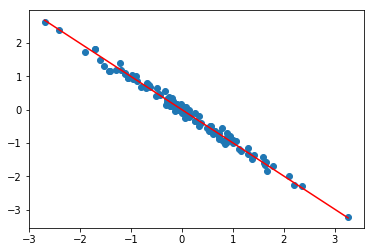

In [70]:
plotLinReg(predictionsAndLabels.rdd)

## Clean up

In [71]:
sc.stop()

In [ ]:
if stopSpark:
    !/home/ggomarr/.spark/sbin/stop-slave.sh
    !/home/ggomarr/.spark/sbin/stop-master.sh